In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Not immediately usable with this dataset as files contain 24-bit data
from scipy.io import wavfile
from scipy.io.wavfile import read, write

import IPython.display as ipd
from IPython.display import Audio
from numpy.fft import fft, ifft
from glob import glob
import librosa as lr
import librosa.display
import os
import pickle
from scipy import signal as sig
from scipy.signal import butter, lfilter
from tqdm import tqdm
import pywt
import random
import skimage.data
from skimage.restoration import denoise_wavelet
import pywt
from pywt import swt
import time as tm

if ('pydub' in globals()) == False:
  !pip install pydub
from pydub import AudioSegment
# from pydub.utils import make_chunks


# LT-06-24: import io to save intermediate outputs; use "as" to shorten module.function name as "spio"
import scipy.io as spio


# LT-06-24: install modules if not found 
if ( 'umap' in globals() ) == False: 
  !pip install umap-learn

import umap.umap_ as umap

import sklearn
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Directory

In [3]:
root = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
outdir = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/Objects/'

# Extract text filenames
textnames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

# Extract audio filenames
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]

textnames = sorted(textnames)
filenames = sorted(filenames)

Information & Annotations

In [4]:
diag_df = pd.read_csv('/content/drive/MyDrive/ICBHI/ICBHI_Challenge_diagnosis.txt', 
                      delimiter='\t',
                      names=['Subject ID', 'Diagnosis'], 
                      header=None)

# Extract file annotation information (start & end of crackles)
def extract_file(filename, root):
    tokens = filename.split('_')
    recording_annotations = pd.read_csv(os.path.join(root, filename + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return recording_annotations

# Information about each file with annotations from each file
def combine_anno_info(names, root):
  information = []
  for file in names:
    anno = extract_file(file, root)
    name_data = file.split('_')
    anno['Subject ID'] = name_data[0]
    anno['Chest Location'] = name_data[2]
    anno['Mode'] = name_data[3]
    anno['Equipment'] = name_data[4]
    anno['Filename'] = file
    information.append(anno)
  return information

anno_info = combine_anno_info(textnames, root)
anno_df = pd.concat(anno_info, ignore_index=True)

# Merge diag_df with anno_df on Subject ID
diag_df['Subject ID'] = diag_df['Subject ID'].astype('int32')
anno_df['Subject ID'] = anno_df['Subject ID'].astype('int32')
sub_anno_df = pd.merge(diag_df, anno_df, on='Subject ID')
sub_anno_df.head()

,Subject ID,Diagnosis,Start,End,Crackles,Wheezes,Chest Location,Mode,Equipment,Filename
0,101,URTI,0.036,0.579,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
1,101,URTI,0.579,2.450,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
2,101,URTI,2.450,3.893,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
3,101,URTI,3.893,5.793,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
4,101,URTI,5.793,7.521,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron


Signals & Sampling Rates

In [5]:
# Get waveforms
def signal_and_sr(filename, root):
    name = root + filename + '.wav'
    signal, sr = lr.load(name, sr=None) # Sampling rate at 4000Hz according to Roche et al., also standard for Eko Duo (typical for librosa but dataset contains more than one sr - 44100, 4000 and 10000)
    return signal, sr

def waveforms(files, root):
  signals = []
  srs = []
  for name in files:
    (sig, sr) = signal_and_sr(name, root) # signal is an array with (sr * duration) values
    # if (len(sig) % 2) == 0: # signal array must be an even number of values for MODWT
    signals.append(sig)
    srs.append(sr)
  return signals, srs

In [6]:
if (os.path.exists(outdir + '/signals.mat') == False):
  signals, srs = waveforms(filenames, root)
  spio.savemat(outdir + 'signals.mat', {'signals': signals, 'srs': srs})
else:
  sig_mat = spio.loadmat(outdir + 'signals.mat', squeeze_me=True)
  signals = sig_mat['signals']
  srs = sig_mat['srs']

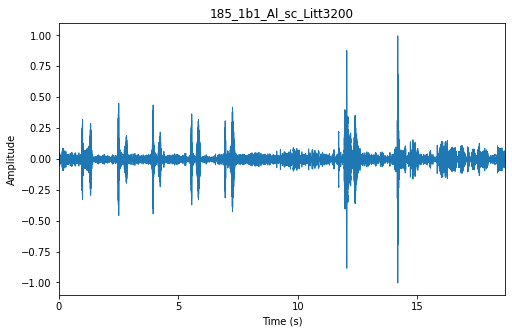

In [7]:
plt.figure(figsize=(8,5))
lr.display.waveplot(signals[648], sr=srs[648])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(filenames[648])
plt.show()

In [8]:
set(srs)

{4000, 10000, 44100}

Audio Slicing

In [7]:
def audio_slice(signals, files, srs, timestamp_df):
  """
  segments the extracted audio signals using timestamp annotations
  """
  slices = []
  for i, s in enumerate(signals):
    filenames = timestamp_df.loc[timestamp_df['Filename'] == files[i]]
    
    for j, row in filenames.iterrows():
      start = row['Start']
      end = row['End']
      audio_seg = slice_signal(start, end, s, srs[i])
      slices.append(audio_seg)
  return slices

def slice_signal(start, end, signal, sr):
  max_index = len(signal)
  start_index = min(int(start * sr), max_index)
  end_index = min(int(end * sr), max_index)
  return signal[start_index:end_index]

In [8]:
if (os.path.exists(outdir + '/slices.mat') == False):
  slices = audio_slice(signals, filenames, srs, sub_anno_df)
  spio.savemat(outdir + 'slices.mat', {'slices': slices})
else:
  slice_mat = spio.loadmat(outdir + 'slices.mat', squeeze_me=True)
  slices = slice_mat['slices']

In [11]:
def slice_df(filenames, timestamp_df):
  """
  compiles the slice names and crackle/wheeze labels into one dataframe
  """
  names = []
  crackles = []
  wheezes = []
  for i, name in enumerate(filenames):
    files = timestamp_df.loc[timestamp_df['Filename'] == name]
    
    for i, row in files.iterrows():
      crackles.append(row['Crackles'])
      wheezes.append(row['Wheezes'])
      names.append(name + "_" + str(i))
  return pd.DataFrame(data = {'Slice Name': names, 'Crackles': crackles, 'Wheezes': wheezes})

In [12]:
slice_anno_df = slice_df(filenames, sub_anno_df)
slice_anno_df.tail()

,Slice Name,Crackles,Wheezes
6893,226_1b1_Pl_sc_LittC2SE_6893,1,0
6894,226_1b1_Pl_sc_LittC2SE_6894,0,0
6895,226_1b1_Pl_sc_LittC2SE_6895,0,0
6896,226_1b1_Pl_sc_LittC2SE_6896,1,0
6897,226_1b1_Pl_sc_LittC2SE_6897,0,0


In [9]:
def slice_rates(timestamp_df, filenames, srs):
    """
    produces list of sample rates for all slices from audio files
    """
    slice_srs = []
    for i, name in enumerate(filenames):
        n_slices = len(timestamp_df[timestamp_df['Filename'] == name])
        slice_srs.extend([srs[i]] * n_slices)
    return slice_srs

slice_srs = slice_rates(sub_anno_df, filenames, srs)

Butterworth Bandpass Filter

In [10]:
def butter_bandpass(lowcut, highcut, sr, order=12):
  nyq = 0.5 * sr
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, sr, order=12):
  b, a = butter_bandpass(lowcut, highcut, sr, order=order)
  y = lfilter(b, a, data)
  return y

Preprocessing

In [11]:
def preprocessing(signals, srs):
  bbfs = [] # Signals are not all the same shape, cannot initialize array without determining maximum columns?
  for i, s in enumerate(signals):
    z = butter_bandpass_filter(s, 120, 1800, srs[i]) 
    bbfs.append(len(z))
  for i, signal in enumerate(signals):
    y = butter_bandpass_filter(signal, 120, 1800, srs[i])
    if i == 0:
      processed = np.zeros((len(signals), max(bbfs)))
    processed[i, :len(y)] = y
  return processed

# for s in slices[0:10]:
#   print(len(butter_bandpass_filter(s, 120, 1800)))

In [ ]:
if (os.path.exists(outdir + '/prepro_slices.mat') == False):
  prepro_slices = preprocessing(slices, slice_srs)
  spio.savemat(outdir + 'prepro_slices.mat', {'prepro_slices': prepro_slices})
else:
  pps_mat = spio.loadmat(outdir + 'prepro_slices.mat', squeeze_me=True)
  prepro_slices = pps_mat['prepro_slices']

Graph Sounds

In [ ]:
def graph_sounds(index, signals, srs, filenames, timestamp_df):
  df = timestamp_df.loc[timestamp_df['Filename'] == filenames[index]]
  signal = signals[index]

  crackles = df.loc[df['Crackles'] >= 1]
  crackle_times = crackles[['Start', 'End']]
  wheezes = df.loc[df['Wheezes'] >= 1]
  wheeze_times = wheezes[['Start', 'End']]

  plt.figure(figsize=(8,5))
  lr.display.waveplot(signal, sr=srs[index], color='g')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(filenames[index])

  if len(crackle_times) != 0:
    for i, row in crackle_times.iterrows():
      plt.axvspan(row[0], row[1], alpha=0.2, color='red')
  
  if len(wheeze_times) != 0:
    for i, row in wheeze_times.iterrows():
      plt.axvspan(row[0], row[1], alpha=0.2, color='blue')
  
  cr = mpatches.Patch(color='red', alpha=0.2, label='Crackle')
  wh = mpatches.Patch(color='blue', alpha=0.2, label='Wheeze')

  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', handles=[cr, wh])

  return plt.show()

In [ ]:
for index, row in sub_anno_df.iterrows():
  if index in range(0, 10):
    print(row['End'] - row['Start'])

0.5429999999999999
1.8710000000000002
1.443
1.899999999999999
1.7280000000000006
1.758
1.8710000000000004
1.8859999999999992
1.6849999999999987
1.9860000000000024


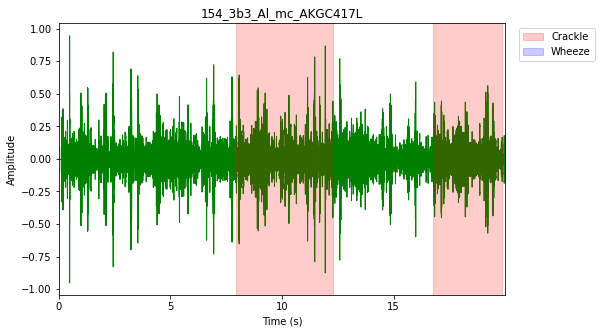

In [ ]:
graph_sounds(352, signals, srs, filenames, sub_anno_df)

Zero-Crossing Rate

In [ ]:
def zcr(signals):
  """
  counts the number of times the signal crosses the horizontal axis
  """
  count = []
  for s in signals:
    count.append(sum(librosa.zero_crossings(s, pad=False)))
  return count

Spectrogram

In [ ]:
def spec_stft(signals):
  """
  converts signals to STFTs to determine the amplitude of frequencies at a given time;
  loudness of a signal over time at various frequencies
  """
  specs = []
  for s in signals:
    stft = librosa.stft(s)
    specs.append(librosa.amplitude_to_db(abs(stft)))
  return specs

Spectral Centroid

In [ ]:
def spec_centroid(signals, sr):
  """
  determines which frequency the energy of a signal spectrum is centered upon;
  center of mass for a sound

  second dimension is the values of spectral centroid across time
  """
  centroids = []
  for s in signals:
    centroids.append(librosa.feature.spectral_centroid(s, sr=sr, n_fft=512, hop_length=256)[0])
  return centroids

Mel-Frequency Cepstral Coefficients

In [ ]:
def mel_freq_cc(signals, sr):
  """
  extracts the timbral information (spectral envelope) of signals
  """
  mfccs = []
  for s in signals:
    mfccs.append(librosa.feature.mfcc(y=s, sr=sr))
  return mfccs

Maximal Overlap Discrete Wavelet Transform

In [ ]:
def modwt(signals, level):
  """
  takes denoised wavelets and performs multiple-overlap 1D stationary
  wavelet transforms (translation-invariance modification of DWT) on each signal
  
  Fraiwan et al. perform a soft MODWT of level 4, but the array data after denoising
  is not long enough so level 1 is selected

  Butterworth bandpass filtering allowed level to be set at 3.

  Output: list of approximation (index 0) & detail (index 1) coefficients
  """
  modwts = []
  for s in signals:
    modwts.append(pywt.swt(s, 'db5', level=level, trim_approx=True, norm=True))
  return modwts